In [1]:
# Parameters
kms_key = "arn:aws:kms:us-west-2:000000000000:1234abcd-12ab-34cd-56ef-1234567890ab"


# MNIST Training with MXNet and Gluon

MNIST is a widely used dataset for handwritten digit classification. It consists of 70,000 labeled 28x28 pixel grayscale images of hand-written digits. The dataset is split into 60,000 training images and 10,000 test images. There are 10 classes (one for each of the 10 digits). This tutorial will show how to train and test an MNIST model on SageMaker using MXNet and the Gluon API.



In [2]:
import os
import boto3
import sagemaker
from sagemaker.mxnet import MXNet
from mxnet import gluon
from sagemaker import get_execution_role

sagemaker_session = sagemaker.Session()

role = get_execution_role()

## Download training and test data

In [3]:
import os

for inner_dir in ["train", "test"]:
    data_dir = "./data/{}/".format(inner_dir)
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)

s3 = boto3.client("s3")
s3.download_file(
    "sagemaker-sample-files",
    "datasets/image/MNIST/train/train-images-idx3-ubyte.gz",
    "./data/train/train-images-idx3-ubyte.gz",
)
s3.download_file(
    "sagemaker-sample-files",
    "datasets/image/MNIST/train/train-labels-idx1-ubyte.gz",
    "./data/train/train-labels-idx1-ubyte.gz",
)
s3.download_file(
    "sagemaker-sample-files",
    "datasets/image/MNIST/test/t10k-images-idx3-ubyte.gz",
    "./data/test/t10k-images-idx3-ubyte.gz",
)
s3.download_file(
    "sagemaker-sample-files",
    "datasets/image/MNIST/test/t10k-labels-idx1-ubyte.gz",
    "./data/test/t10k-labels-idx1-ubyte.gz",
)

## Uploading the data

We use the `sagemaker.Session.upload_data` function to upload our datasets to an S3 location. The return value `inputs` identifies the location -- we will use this later when we start the training job.

In [4]:
inputs = sagemaker_session.upload_data(path="data", key_prefix="data/DEMO-mnist")

## Implement the training function

We need to provide a training script that can run on the SageMaker platform. The training scripts are essentially the same as one you would write for local training, except that you need to provide a `train` function. The `train` function will check for the validation accuracy at the end of every epoch and checkpoints the best model so far, along with the optimizer state, in the folder `/opt/ml/checkpoints` if the folder path exists, else it will skip the checkpointing. When SageMaker calls your function, it will pass in arguments that describe the training environment. Check the script below to see how this works.

The script here is an adaptation of the [Gluon MNIST example](https://github.com/apache/incubator-mxnet/blob/master/example/gluon/mnist.py) provided by the [Apache MXNet](https://mxnet.incubator.apache.org/) project. 

In [5]:
!cat 'mnist.py'

from __future__ import print_function

import argparse
import json
import logging
import os
import time

import mxnet as mx
import numpy as np
from mxnet import autograd, gluon
from mxnet.gluon import nn

logging.basicConfig(level=logging.DEBUG)

# ------------------------------------------------------------ #
# Training methods                                             #
# ------------------------------------------------------------ #


def train(args):
    # SageMaker passes num_cpus, num_gpus and other args we can use to tailor training to
    # the current container environment, but here we just use simple cpu context.
    ctx = mx.cpu()

    # retrieve the hyperparameters we set in notebook (with some defaults)
    batch_size = args.batch_size
    epochs = args.epochs
    learning_rate = args.learning_rate
    momentum = args.momentum
    log_interval = args.log_interval

    num_gpus = int(os.environ["SM_NUM_GPUS"])
    current_host = args.current_host
    hosts = args.hosts
  

## Run the training script on SageMaker

The ```MXNet``` class allows us to run our training function on SageMaker infrastructure. We need to configure it with our training script, an IAM role, the number of training instances, and the training instance type. In this case we will run our training job on a single c4.xlarge instance. 

In [6]:
m = MXNet(
    "mnist.py",
    role=role,
    instance_count=1,
    instance_type="ml.c4.xlarge",
    framework_version="1.6.0",
    py_version="py3",
    hyperparameters={
        "batch-size": 100,
        "epochs": 20,
        "learning-rate": 0.1,
        "momentum": 0.9,
        "log-interval": 100,
    },
)

After we've constructed our `MXNet` object, we can fit it using the data we uploaded to S3. SageMaker makes sure our data is available in the local filesystem, so our training script can simply read the data from disk.


In [7]:
m.fit(inputs)

2022-04-07 13:01:14 Starting - Starting the training job.

.

.


2022-04-07 13:01:40 Starting - Preparing the instances for trainingProfilerReport-1649336474: InProgress
.

.

.

.

.

.

.

.

.


2022-04-07 13:02:58 Downloading - Downloading input data.

.

.


2022-04-07 13:03:39 Training - Downloading the training image.

.

2022-04-07 13:03:49,400 sagemaker-training-toolkit INFO     Imported framework sagemaker_mxnet_container.training
2022-04-07 13:03:49,402 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-04-07 13:03:49,418 sagemaker_mxnet_container.training INFO     MXNet training environment: {'SM_HOSTS': '["algo-1"]', 'SM_NETWORK_INTERFACE_NAME': 'eth0', 'SM_HPS': '{"batch-size":100,"epochs":20,"learning-rate":0.1,"log-interval":100,"momentum":0.9}', 'SM_USER_ENTRY_POINT': 'mnist.py', 'SM_FRAMEWORK_PARAMS': '{}', 'SM_RESOURCE_CONFIG': '{"current_group_name":"homogeneousCluster","current_host":"algo-1","current_instance_type":"ml.c4.xlarge","hosts":["algo-1"],"instance_groups":[{"hosts":["algo-1"],"instance_group_name":"homogeneousCluster","instance_type":"ml.c4.xlarge"}],"network_interface_name":"eth0"}', 'SM_INPUT_DATA_CONFIG': '{"training":{"RecordWrapperType":"None","S3DistributionType":"FullyReplicated","TrainingInputMode":"File"}}', 'SM_OUTPUT_DATA_DIR': '/


2022-04-07 13:03:59 Training - Training image download completed. Training in progress.

[Epoch 0 Batch 300] Training: accuracy=0.880698, 4003.879491 samples/s
[Epoch 0 Batch 400] Training: accuracy=0.896209, 2537.481094 samples/s
[Epoch 0 Batch 500] Training: accuracy=0.907385, 3033.854611 samples/s
DEBUG:root:Writing metric: _RawMetricData(MetricName='softmaxcrossentropyloss0_output_0_GLOBAL',Value=0.09916237741708755,Timestamp=1649336649.0394568,IterationNumber=500)
[Epoch 0] Training: accuracy=0.914917


[Epoch 0] Validation: accuracy=0.960300
[Epoch 1 Batch 100] Training: accuracy=0.962475, 3578.910363 samples/s
[Epoch 1 Batch 200] Training: accuracy=0.963632, 3591.474933 samples/s
[Epoch 1 Batch 300] Training: accuracy=0.963654, 3579.796187 samples/s
DEBUG:root:Writing metric: _RawMetricData(MetricName='softmaxcrossentropyloss0_output_0_GLOBAL',Value=0.03393222764134407,Timestamp=1649336663.109417,IterationNumber=1000)


[Epoch 1 Batch 400] Training: accuracy=0.963067, 2568.622696 samples/s
[Epoch 1 Batch 500] Training: accuracy=0.963972, 3303.902324 samples/s


[Epoch 1] Training: accuracy=0.964300
[Epoch 1] Validation: accuracy=0.969300
[Epoch 2 Batch 100] Training: accuracy=0.972871, 3869.783920 samples/s
DEBUG:root:Writing metric: _RawMetricData(MetricName='softmaxcrossentropyloss0_output_0_GLOBAL',Value=0.056217584758996964,Timestamp=1649336677.2218242,IterationNumber=1500)
[Epoch 2 Batch 200] Training: accuracy=0.971891, 3156.507473 samples/s


[Epoch 2 Batch 300] Training: accuracy=0.973289, 3292.981919 samples/s
[Epoch 2 Batch 400] Training: accuracy=0.973491, 3426.522993 samples/s
[Epoch 2 Batch 500] Training: accuracy=0.973852, 1552.968532 samples/s
[Epoch 2] Training: accuracy=0.973833


[Epoch 2] Validation: accuracy=0.969600
[Epoch 3 Batch 100] Training: accuracy=0.978416, 4028.878259 samples/s
[Epoch 3 Batch 200] Training: accuracy=0.978259, 3804.667955 samples/s
[Epoch 3 Batch 300] Training: accuracy=0.979236, 2918.365444 samples/s


[Epoch 3 Batch 400] Training: accuracy=0.978853, 2034.292366 samples/s
DEBUG:root:Writing metric: _RawMetricData(MetricName='softmaxcrossentropyloss0_output_0_GLOBAL',Value=0.11119231581687927,Timestamp=1649336706.1482356,IterationNumber=2500)
[Epoch 3 Batch 500] Training: accuracy=0.978483, 3761.167904 samples/s
[Epoch 3] Training: accuracy=0.979183
[Epoch 3] Validation: accuracy=0.972000


[Epoch 4 Batch 100] Training: accuracy=0.985446, 4131.260958 samples/s
[Epoch 4 Batch 200] Training: accuracy=0.985821, 3185.732840 samples/s
DEBUG:root:Writing metric: _RawMetricData(MetricName='softmaxcrossentropyloss0_output_0_GLOBAL',Value=0.03907652944326401,Timestamp=1649336720.271122,IterationNumber=3000)
[Epoch 4 Batch 300] Training: accuracy=0.984352, 4386.383744 samples/s
[Epoch 4 Batch 400] Training: accuracy=0.983716, 3662.315981 samples/s


[Epoch 4 Batch 500] Training: accuracy=0.982715, 2999.230582 samples/s
[Epoch 4] Training: accuracy=0.982500


[Epoch 4] Validation: accuracy=0.973800
DEBUG:root:Writing metric: _RawMetricData(MetricName='softmaxcrossentropyloss0_output_0_GLOBAL',Value=0.013364442624151707,Timestamp=1649336734.5065677,IterationNumber=3500)
[Epoch 5 Batch 100] Training: accuracy=0.987822, 3143.142765 samples/s
[Epoch 5 Batch 200] Training: accuracy=0.987662, 3115.731297 samples/s
[Epoch 5 Batch 300] Training: accuracy=0.986910, 3235.297203 samples/s


[Epoch 5 Batch 400] Training: accuracy=0.986459, 4042.157203 samples/s
[Epoch 5 Batch 500] Training: accuracy=0.985908, 3114.805766 samples/s
DEBUG:root:Writing metric: _RawMetricData(MetricName='softmaxcrossentropyloss0_output_0_GLOBAL',Value=0.03384695574641228,Timestamp=1649336748.8210685,IterationNumber=4000)
[Epoch 5] Training: accuracy=0.985433
[Epoch 5] Validation: accuracy=0.975200


[Epoch 6 Batch 100] Training: accuracy=0.988713, 2979.353455 samples/s
[Epoch 6 Batch 200] Training: accuracy=0.988756, 3665.933067 samples/s
[Epoch 6 Batch 300] Training: accuracy=0.988671, 3661.804404 samples/s
DEBUG:root:Writing metric: _RawMetricData(MetricName='softmaxcrossentropyloss0_output_0_GLOBAL',Value=0.03091752529144287,Timestamp=1649336762.9129343,IterationNumber=4500)
[Epoch 6 Batch 400] Training: accuracy=0.988155, 2873.322646 samples/s


[Epoch 6 Batch 500] Training: accuracy=0.987545, 3455.742675 samples/s
[Epoch 6] Training: accuracy=0.986817
[Epoch 6] Validation: accuracy=0.973400
[Epoch 7 Batch 100] Training: accuracy=0.986436, 2784.267440 samples/s
DEBUG:root:Writing metric: _RawMetricData(MetricName='softmaxcrossentropyloss0_output_0_GLOBAL',Value=0.030776305124163628,Timestamp=1649336777.3608341,IterationNumber=5000)


[Epoch 7 Batch 200] Training: accuracy=0.988706, 3343.167090 samples/s
[Epoch 7 Batch 300] Training: accuracy=0.989402, 4013.534410 samples/s


[Epoch 7 Batch 400] Training: accuracy=0.989426, 3521.015430 samples/s
[Epoch 7 Batch 500] Training: accuracy=0.989042, 3665.356416 samples/s
[Epoch 7] Training: accuracy=0.988700
[Epoch 7] Validation: accuracy=0.972600


[Epoch 8 Batch 100] Training: accuracy=0.991980, 4037.449102 samples/s
[Epoch 8 Batch 200] Training: accuracy=0.991642, 3433.647966 samples/s
[Epoch 8 Batch 300] Training: accuracy=0.990897, 3497.235100 samples/s
[Epoch 8 Batch 400] Training: accuracy=0.990374, 3336.677724 samples/s
DEBUG:root:Writing metric: _RawMetricData(MetricName='softmaxcrossentropyloss0_output_0_GLOBAL',Value=0.02948686294257641,Timestamp=1649336805.674257,IterationNumber=6000)


[Epoch 8 Batch 500] Training: accuracy=0.990000, 4026.789555 samples/s
[Epoch 8] Training: accuracy=0.989900
[Epoch 8] Validation: accuracy=0.973900
[Epoch 9 Batch 100] Training: accuracy=0.993465, 3420.598765 samples/s


[Epoch 9 Batch 200] Training: accuracy=0.992338, 2793.130223 samples/s
DEBUG:root:Writing metric: _RawMetricData(MetricName='softmaxcrossentropyloss0_output_0_GLOBAL',Value=0.05277693644165993,Timestamp=1649336819.6829388,IterationNumber=6500)
[Epoch 9 Batch 300] Training: accuracy=0.990266, 4180.591659 samples/s
[Epoch 9 Batch 400] Training: accuracy=0.990673, 3554.856426 samples/s
[Epoch 9 Batch 500] Training: accuracy=0.990519, 2786.079910 samples/s


[Epoch 9] Training: accuracy=0.990083
[Epoch 9] Validation: accuracy=0.977100
DEBUG:root:Writing metric: _RawMetricData(MetricName='softmaxcrossentropyloss0_output_0_GLOBAL',Value=0.001532559865154326,Timestamp=1649336834.2309086,IterationNumber=7000)
[Epoch 10 Batch 100] Training: accuracy=0.993069, 3324.986325 samples/s
[Epoch 10 Batch 200] Training: accuracy=0.992537, 3170.681262 samples/s


[Epoch 10 Batch 300] Training: accuracy=0.992591, 3081.577265 samples/s
[Epoch 10 Batch 400] Training: accuracy=0.992344, 3743.009361 samples/s


[Epoch 10 Batch 500] Training: accuracy=0.991916, 3387.912958 samples/s
DEBUG:root:Writing metric: _RawMetricData(MetricName='softmaxcrossentropyloss0_output_0_GLOBAL',Value=0.00295252469368279,Timestamp=1649336848.7014928,IterationNumber=7500)
[Epoch 10] Training: accuracy=0.991583
[Epoch 10] Validation: accuracy=0.975100
[Epoch 11 Batch 100] Training: accuracy=0.991881, 3082.619081 samples/s


[Epoch 11 Batch 200] Training: accuracy=0.992139, 3257.914278 samples/s
[Epoch 11 Batch 300] Training: accuracy=0.992259, 3602.301733 samples/s
DEBUG:root:Writing metric: _RawMetricData(MetricName='softmaxcrossentropyloss0_output_0_GLOBAL',Value=0.02161409892141819,Timestamp=1649336862.7083972,IterationNumber=8000)
[Epoch 11 Batch 400] Training: accuracy=0.991771, 3057.050605 samples/s
[Epoch 11 Batch 500] Training: accuracy=0.990858, 2905.306614 samples/s


[Epoch 11] Training: accuracy=0.991117
[Epoch 11] Validation: accuracy=0.972000
[Epoch 12 Batch 100] Training: accuracy=0.993168, 3003.827203 samples/s
DEBUG:root:Writing metric: _RawMetricData(MetricName='softmaxcrossentropyloss0_output_0_GLOBAL',Value=0.013427884317934513,Timestamp=1649336876.9875906,IterationNumber=8500)
[Epoch 12 Batch 200] Training: accuracy=0.994030, 4109.202418 samples/s


[Epoch 12 Batch 300] Training: accuracy=0.993987, 3856.157545 samples/s
[Epoch 12 Batch 400] Training: accuracy=0.993491, 2719.812208 samples/s
[Epoch 12 Batch 500] Training: accuracy=0.993513, 4009.084305 samples/s
[Epoch 12] Training: accuracy=0.993350


[Epoch 12] Validation: accuracy=0.975800
[Epoch 13 Batch 100] Training: accuracy=0.995050, 4109.282936 samples/s


[Epoch 13 Batch 200] Training: accuracy=0.995274, 3560.378592 samples/s
[Epoch 13 Batch 300] Training: accuracy=0.995183, 3372.358953 samples/s
[Epoch 13 Batch 400] Training: accuracy=0.994888, 3218.341838 samples/s
DEBUG:root:Writing metric: _RawMetricData(MetricName='softmaxcrossentropyloss0_output_0_GLOBAL',Value=0.02135235257446766,Timestamp=1649336906.0568547,IterationNumber=9500)
[Epoch 13 Batch 500] Training: accuracy=0.994331, 3189.778846 samples/s


[Epoch 13] Training: accuracy=0.994067
[Epoch 13] Validation: accuracy=0.977700
[Epoch 14 Batch 100] Training: accuracy=0.994851, 3206.090672 samples/s
[Epoch 14 Batch 200] Training: accuracy=0.994627, 2881.019892 samples/s
DEBUG:root:Writing metric: _RawMetricData(MetricName='softmaxcrossentropyloss0_output_0_GLOBAL',Value=0.012653316371142864,Timestamp=1649336922.4464872,IterationNumber=10000)


[Epoch 14 Batch 300] Training: accuracy=0.994551, 3414.278039 samples/s
[Epoch 14 Batch 400] Training: accuracy=0.994414, 2874.326871 samples/s
[Epoch 14 Batch 500] Training: accuracy=0.993952, 3253.138500 samples/s
[Epoch 14] Training: accuracy=0.993433


[Epoch 14] Validation: accuracy=0.975100
DEBUG:root:Writing metric: _RawMetricData(MetricName='softmaxcrossentropyloss0_output_0_GLOBAL',Value=0.003257656702771783,Timestamp=1649336936.8034856,IterationNumber=10500)
[Epoch 15 Batch 100] Training: accuracy=0.991188, 3443.090512 samples/s


[Epoch 15 Batch 200] Training: accuracy=0.990647, 3290.579301 samples/s
[Epoch 15 Batch 300] Training: accuracy=0.990997, 2918.649753 samples/s
[Epoch 15 Batch 400] Training: accuracy=0.991372, 3561.134318 samples/s
[Epoch 15 Batch 500] Training: accuracy=0.991796, 3384.086105 samples/s
DEBUG:root:Writing metric: _RawMetricData(MetricName='softmaxcrossentropyloss0_output_0_GLOBAL',Value=0.0009113451815210283,Timestamp=1649336951.85284,IterationNumber=11000)


[Epoch 15] Training: accuracy=0.991850
[Epoch 15] Validation: accuracy=0.973200
[Epoch 16 Batch 100] Training: accuracy=0.996040, 3181.093810 samples/s
[Epoch 16 Batch 200] Training: accuracy=0.994826, 3454.348095 samples/s


[Epoch 16 Batch 300] Training: accuracy=0.994120, 3702.762304 samples/s
DEBUG:root:Writing metric: _RawMetricData(MetricName='softmaxcrossentropyloss0_output_0_GLOBAL',Value=0.009854916483163834,Timestamp=1649336966.0536022,IterationNumber=11500)
[Epoch 16 Batch 400] Training: accuracy=0.994165, 3697.148448 samples/s
[Epoch 16 Batch 500] Training: accuracy=0.994032, 3988.535456 samples/s
[Epoch 16] Training: accuracy=0.994117


[Epoch 16] Validation: accuracy=0.976100
[Epoch 17 Batch 100] Training: accuracy=0.995446, 2939.946448 samples/s
DEBUG:root:Writing metric: _RawMetricData(MetricName='softmaxcrossentropyloss0_output_0_GLOBAL',Value=0.006457247771322727,Timestamp=1649336980.2468355,IterationNumber=12000)


[Epoch 17 Batch 200] Training: accuracy=0.995473, 3980.964132 samples/s
[Epoch 17 Batch 300] Training: accuracy=0.995615, 3352.117899 samples/s
[Epoch 17 Batch 400] Training: accuracy=0.995087, 3365.107790 samples/s
[Epoch 17 Batch 500] Training: accuracy=0.994631, 3517.678534 samples/s


[Epoch 17] Training: accuracy=0.994067
[Epoch 17] Validation: accuracy=0.976800
[Epoch 18 Batch 100] Training: accuracy=0.996832, 4041.066749 samples/s
[Epoch 18 Batch 200] Training: accuracy=0.996020, 3253.592733 samples/s


[Epoch 18 Batch 300] Training: accuracy=0.995615, 3183.170038 samples/s
[Epoch 18 Batch 400] Training: accuracy=0.995411, 3288.644258 samples/s
DEBUG:root:Writing metric: _RawMetricData(MetricName='softmaxcrossentropyloss0_output_0_GLOBAL',Value=0.10177836567163467,Timestamp=1649337009.1946185,IterationNumber=13000)
[Epoch 18 Batch 500] Training: accuracy=0.995469, 3033.196413 samples/s
[Epoch 18] Training: accuracy=0.995383


[Epoch 18] Validation: accuracy=0.978200
[Epoch 19 Batch 100] Training: accuracy=0.995545, 3132.929981 samples/s
[Epoch 19 Batch 200] Training: accuracy=0.995622, 2912.731338 samples/s
DEBUG:root:Writing metric: _RawMetricData(MetricName='softmaxcrossentropyloss0_output_0_GLOBAL',Value=0.0034309551119804382,Timestamp=1649337023.3236864,IterationNumber=13500)
[Epoch 19 Batch 300] Training: accuracy=0.995814, 3485.204328 samples/s


[Epoch 19 Batch 400] Training: accuracy=0.996010, 3028.837585 samples/s
[Epoch 19 Batch 500] Training: accuracy=0.995589, 3648.807308 samples/s


[Epoch 19] Training: accuracy=0.995683
[Epoch 19] Validation: accuracy=0.979200
2022-04-07 13:10:37,836 sagemaker-training-toolkit INFO     Reporting training SUCCESS



2022-04-07 13:10:47 Uploading - Uploading generated training model
2022-04-07 13:10:47 Completed - Training job completed


Training seconds: 471
Billable seconds: 471


After training, we use the MXNet object to build and deploy an MXNetPredictor object. This creates a SageMaker endpoint that we can use to perform inference. 

This allows us to perform inference on json encoded multi-dimensional arrays. 

In [8]:
predictor = m.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")

-

-

-

-

-

-

-

!

We can now use this predictor to classify hand-written digits. Manually drawing into the image box loads the pixel data into a 'data' variable in this notebook, which we can then pass to the MXNet predictor. 

In [9]:
from IPython.display import HTML

HTML(open("input.html").read())

Fetch the first image from the test dataset and display it.

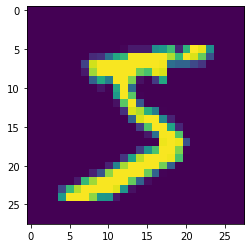

In [10]:
import gzip
import numpy as np
import matplotlib.pyplot as plt

f = gzip.open("data/train/train-images-idx3-ubyte.gz", "r")

image_size = 28

f.read(16)
buf = f.read(image_size * image_size)
data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
data = data.reshape(1, image_size, image_size, 1)

image = np.asarray(data).squeeze()
plt.imshow(image)
plt.show()

The predictor runs inference on our input data and returns the predicted digit (as a float value, so we convert to int for display).

In [11]:
response = predictor.predict(data)
print(int(response))

5


## Cleanup

After you have finished with this example, remember to delete the prediction endpoint to release the instance(s) associated with it.

In [12]:
predictor.delete_endpoint()